# Definicja modelu

In [1]:
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, dw_kernel_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        init_channels = oup // 2
        new_channels = oup - init_channels

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_kernel_size, 1, dw_kernel_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

    def forward(self, x):
        primary_output = self.primary_conv(x)
        cheap_output = self.cheap_operation(primary_output)
        return torch.cat([primary_output, cheap_output], dim=1)


class GhostNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(GhostNet, self).__init__()
        self.conv_stem = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.ghost_block = nn.Sequential(
            GhostModule(16, 32, relu=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            GhostModule(32, 64, relu=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            GhostModule(64, 128, relu=True),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.ghost_block(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# GhostNet + GRU
class GhostNetGRU(nn.Module):
    def __init__(self, num_classes, input_channels=1, hidden_size=256):
        super(GhostNetGRU, self).__init__()
        # GhostNet as feature extractor
        self.ghostnet = GhostNet(num_classes=hidden_size, input_channels=input_channels)
        
        # GRU layer
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Final classification layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Extract features using GhostNet
        batch_size, c, h, w = x.size()  # x: (batch, seq, channels, height, width)
        seq_len = 1
        x = x.view(batch_size * seq_len, c, h, w)
        features = self.ghostnet(x)  # (batch * seq_len, feature_dim)
        
        # Reshape for GRU input (batch, seq_len, feature_dim)
        features = features.view(batch_size, seq_len, -1)
        
        # GRU
        gru_out, _ = self.gru(features)
        
        # Classification
        output = self.fc(gru_out[:, -1, :])  # Use the last GRU output
        return output

# Dane treningowe i walidacyjne

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [5]:
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform

        # Przygotowanie listy plików i odpowiadających etykiet
        self.samples = []
        for class_name, label in labels_dict.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    if file_path.endswith((".png", ".jpg", ".jpeg")):  # Obsługiwane formaty
                        self.samples.append((file_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Wczytanie obrazu i zastosowanie transformacji
        image = Image.open(file_path).convert("L")  # Konwersja na RGB
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
batch_size = 128
labels_dict = {
    "Alauda arvensis": 0,
    "Anas platyrhynchos": 1,
    "Anser albifrons": 2,
    "Anser fabalis": 3,
    "Apus apus": 4,
    "Chroicocephalus ridibundus": 5,
    "Coloeus monedula": 6,
    "Columba livia": 7,
    "Columba palumbus": 8,
    "Corvus frugilegus": 9,
    "Cuculus canorus": 10,
    "Cyanistes caeruleus": 11,
    "Delichon urbicum": 12,
    "Fulica atra": 13,
    "Garrulus glandarius": 14,
    "Luscinia luscinia": 15,
    "Luscinia megarhynchos": 16,
    "Pica pica": 17,
    "Riparia riparia": 18,
    "Sitta europaea": 19}

# Transformacje (np. skalowanie obrazu do 224x224 i normalizacja)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Skalowanie do stałego rozmiaru
    transforms.ToTensor(),  # Konwersja na tensor
    transforms.Lambda(lambda t: t/255.)  # Normalizacja
])

dataset_train = SpectrogramDataset(root_dir="../data/merged-data/train", labels_dict=labels_dict, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = SpectrogramDataset(root_dir="../data/merged-data/val", labels_dict=labels_dict, transform=transform)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Trening

In [7]:
import torch.optim as optim
from tqdm import tqdm

history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

# Funkcja treningowa
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, save_path="best_model.pth"):
    model.to(device)
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        # Tryb treningu
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Optymalizacja
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statystyki treningowe
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_accuracy = correct_train / total_train

        # Walidacja
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_accuracy = correct_val / total_val
        
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # Wyświetlenie statystyk
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Zapis najlepszego modelu
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with Val Loss: {val_loss:.4f}")

# Model, kryterium i optymalizator
model = GhostNetGRU(num_classes=len(labels_dict.keys()), input_channels=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
train(
    model=model,
    train_loader=dataloader_train,
    val_loader=dataloader_val,
    num_epochs=100,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    save_path="ghostnet_model.pth"
)

batch: 100%|██████████| 657/657 [10:49<00:00,  1.01it/s]


Epoch 1/100
Train Loss: 1.7449, Train Accuracy: 0.4636
Val Loss: 1.5325, Val Accuracy: 0.5150
Best model saved with Val Loss: 1.5325


batch: 100%|██████████| 657/657 [11:44<00:00,  1.07s/it]


Epoch 2/100
Train Loss: 1.1985, Train Accuracy: 0.6310
Val Loss: 1.2704, Val Accuracy: 0.6007
Best model saved with Val Loss: 1.2704


batch: 100%|██████████| 657/657 [10:39<00:00,  1.03it/s]


Epoch 3/100
Train Loss: 1.0035, Train Accuracy: 0.6940
Val Loss: 1.1165, Val Accuracy: 0.6705
Best model saved with Val Loss: 1.1165


batch: 100%|██████████| 657/657 [12:03<00:00,  1.10s/it]


Epoch 4/100
Train Loss: 0.8895, Train Accuracy: 0.7293
Val Loss: 0.8396, Val Accuracy: 0.7423
Best model saved with Val Loss: 0.8396


batch: 100%|██████████| 657/657 [13:31<00:00,  1.24s/it]


Epoch 5/100
Train Loss: 0.8178, Train Accuracy: 0.7505
Val Loss: 0.8366, Val Accuracy: 0.7457
Best model saved with Val Loss: 0.8366


batch: 100%|██████████| 657/657 [12:18<00:00,  1.12s/it]


Epoch 6/100
Train Loss: 0.7725, Train Accuracy: 0.7654
Val Loss: 0.7560, Val Accuracy: 0.7699
Best model saved with Val Loss: 0.7560


batch: 100%|██████████| 657/657 [12:22<00:00,  1.13s/it]


Epoch 7/100
Train Loss: 0.7305, Train Accuracy: 0.7775
Val Loss: 0.6970, Val Accuracy: 0.7927
Best model saved with Val Loss: 0.6970


batch: 100%|██████████| 657/657 [11:51<00:00,  1.08s/it]


Epoch 8/100
Train Loss: 0.6927, Train Accuracy: 0.7894
Val Loss: 0.7048, Val Accuracy: 0.7873


batch: 100%|██████████| 657/657 [12:33<00:00,  1.15s/it]


Epoch 9/100
Train Loss: 0.6630, Train Accuracy: 0.7989
Val Loss: 0.7028, Val Accuracy: 0.7916


batch: 100%|██████████| 657/657 [11:42<00:00,  1.07s/it]


Epoch 10/100
Train Loss: 0.6364, Train Accuracy: 0.8046
Val Loss: 0.6621, Val Accuracy: 0.8024
Best model saved with Val Loss: 0.6621


batch: 100%|██████████| 657/657 [12:24<00:00,  1.13s/it]


Epoch 11/100
Train Loss: 0.6175, Train Accuracy: 0.8105
Val Loss: 0.6334, Val Accuracy: 0.8092
Best model saved with Val Loss: 0.6334


batch: 100%|██████████| 657/657 [12:33<00:00,  1.15s/it]


Epoch 12/100
Train Loss: 0.5948, Train Accuracy: 0.8181
Val Loss: 0.6385, Val Accuracy: 0.8089


batch: 100%|██████████| 657/657 [11:53<00:00,  1.09s/it]


Epoch 13/100
Train Loss: 0.5757, Train Accuracy: 0.8233
Val Loss: 0.6255, Val Accuracy: 0.8128
Best model saved with Val Loss: 0.6255


batch: 100%|██████████| 657/657 [13:37<00:00,  1.24s/it]


Epoch 14/100
Train Loss: 0.5532, Train Accuracy: 0.8309
Val Loss: 0.6290, Val Accuracy: 0.8138


batch: 100%|██████████| 657/657 [12:56<00:00,  1.18s/it]


Epoch 15/100
Train Loss: 0.5395, Train Accuracy: 0.8339
Val Loss: 0.6136, Val Accuracy: 0.8159
Best model saved with Val Loss: 0.6136


batch: 100%|██████████| 657/657 [12:45<00:00,  1.16s/it]


Epoch 16/100
Train Loss: 0.5232, Train Accuracy: 0.8394
Val Loss: 0.6285, Val Accuracy: 0.8127


batch: 100%|██████████| 657/657 [12:24<00:00,  1.13s/it]


Epoch 17/100
Train Loss: 0.5102, Train Accuracy: 0.8432
Val Loss: 0.5888, Val Accuracy: 0.8220
Best model saved with Val Loss: 0.5888


batch: 100%|██████████| 657/657 [12:22<00:00,  1.13s/it]


Epoch 18/100
Train Loss: 0.4982, Train Accuracy: 0.8464
Val Loss: 0.7074, Val Accuracy: 0.7893


batch: 100%|██████████| 657/657 [13:09<00:00,  1.20s/it]


Epoch 19/100
Train Loss: 0.4847, Train Accuracy: 0.8509
Val Loss: 0.6703, Val Accuracy: 0.8042


batch: 100%|██████████| 657/657 [13:19<00:00,  1.22s/it]


Epoch 20/100
Train Loss: 0.4738, Train Accuracy: 0.8538
Val Loss: 0.6060, Val Accuracy: 0.8226


batch: 100%|██████████| 657/657 [15:58<00:00,  1.46s/it]


Epoch 21/100
Train Loss: 0.4671, Train Accuracy: 0.8564
Val Loss: 0.5985, Val Accuracy: 0.8247


batch: 100%|██████████| 657/657 [12:21<00:00,  1.13s/it]


Epoch 22/100
Train Loss: 0.4538, Train Accuracy: 0.8598
Val Loss: 0.6300, Val Accuracy: 0.8129


batch: 100%|██████████| 657/657 [10:58<00:00,  1.00s/it]


Epoch 23/100
Train Loss: 0.4436, Train Accuracy: 0.8612
Val Loss: 0.5966, Val Accuracy: 0.8245


batch: 100%|██████████| 657/657 [11:14<00:00,  1.03s/it]


Epoch 24/100
Train Loss: 0.4369, Train Accuracy: 0.8637
Val Loss: 0.5813, Val Accuracy: 0.8312
Best model saved with Val Loss: 0.5813


batch: 100%|██████████| 657/657 [11:08<00:00,  1.02s/it]


Epoch 25/100
Train Loss: 0.4243, Train Accuracy: 0.8672
Val Loss: 0.6085, Val Accuracy: 0.8212


batch: 100%|██████████| 657/657 [11:01<00:00,  1.01s/it]


Epoch 26/100
Train Loss: 0.4174, Train Accuracy: 0.8703
Val Loss: 0.5695, Val Accuracy: 0.8306
Best model saved with Val Loss: 0.5695


batch: 100%|██████████| 657/657 [11:00<00:00,  1.01s/it]


Epoch 27/100
Train Loss: 0.4129, Train Accuracy: 0.8712
Val Loss: 0.5639, Val Accuracy: 0.8357
Best model saved with Val Loss: 0.5639


batch: 100%|██████████| 657/657 [11:03<00:00,  1.01s/it]


Epoch 28/100
Train Loss: 0.3993, Train Accuracy: 0.8762
Val Loss: 0.5763, Val Accuracy: 0.8350


batch: 100%|██████████| 657/657 [11:01<00:00,  1.01s/it]


Epoch 29/100
Train Loss: 0.3912, Train Accuracy: 0.8772
Val Loss: 0.6262, Val Accuracy: 0.8212


batch: 100%|██████████| 657/657 [11:11<00:00,  1.02s/it]


Epoch 30/100
Train Loss: 0.3900, Train Accuracy: 0.8787
Val Loss: 0.5920, Val Accuracy: 0.8287


batch: 100%|██████████| 657/657 [12:02<00:00,  1.10s/it]


Epoch 31/100
Train Loss: 0.3825, Train Accuracy: 0.8807
Val Loss: 0.6007, Val Accuracy: 0.8307


batch: 100%|██████████| 657/657 [13:12<00:00,  1.21s/it]


Epoch 32/100
Train Loss: 0.3783, Train Accuracy: 0.8806
Val Loss: 0.5746, Val Accuracy: 0.8374


batch: 100%|██████████| 657/657 [11:44<00:00,  1.07s/it]


Epoch 33/100
Train Loss: 0.3667, Train Accuracy: 0.8846
Val Loss: 0.5970, Val Accuracy: 0.8296


batch: 100%|██████████| 657/657 [11:25<00:00,  1.04s/it]


Epoch 34/100
Train Loss: 0.3659, Train Accuracy: 0.8852
Val Loss: 0.5605, Val Accuracy: 0.8373
Best model saved with Val Loss: 0.5605


batch: 100%|██████████| 657/657 [11:48<00:00,  1.08s/it]


Epoch 35/100
Train Loss: 0.3527, Train Accuracy: 0.8884
Val Loss: 0.5313, Val Accuracy: 0.8520
Best model saved with Val Loss: 0.5313


batch: 100%|██████████| 657/657 [10:53<00:00,  1.00it/s]


Epoch 36/100
Train Loss: 0.3482, Train Accuracy: 0.8901
Val Loss: 0.6167, Val Accuracy: 0.8256


batch: 100%|██████████| 657/657 [11:57<00:00,  1.09s/it]


Epoch 37/100
Train Loss: 0.3477, Train Accuracy: 0.8894
Val Loss: 0.5861, Val Accuracy: 0.8396


batch: 100%|██████████| 657/657 [15:53<00:00,  1.45s/it]


Epoch 38/100
Train Loss: 0.3401, Train Accuracy: 0.8921
Val Loss: 0.5974, Val Accuracy: 0.8364


batch: 100%|██████████| 657/657 [10:14<00:00,  1.07it/s]


Epoch 39/100
Train Loss: 0.3342, Train Accuracy: 0.8937
Val Loss: 0.6109, Val Accuracy: 0.8354


batch: 100%|██████████| 657/657 [10:46<00:00,  1.02it/s]


Epoch 40/100
Train Loss: 0.3296, Train Accuracy: 0.8947
Val Loss: 0.5761, Val Accuracy: 0.8396


batch: 100%|██████████| 657/657 [10:38<00:00,  1.03it/s]


Epoch 41/100
Train Loss: 0.3255, Train Accuracy: 0.8960
Val Loss: 0.5743, Val Accuracy: 0.8415


batch: 100%|██████████| 657/657 [10:14<00:00,  1.07it/s]


Epoch 42/100
Train Loss: 0.3236, Train Accuracy: 0.8964
Val Loss: 0.5598, Val Accuracy: 0.8465


batch: 100%|██████████| 657/657 [10:12<00:00,  1.07it/s]


Epoch 43/100
Train Loss: 0.3153, Train Accuracy: 0.9001
Val Loss: 0.6099, Val Accuracy: 0.8323


batch: 100%|██████████| 657/657 [10:07<00:00,  1.08it/s]


Epoch 44/100
Train Loss: 0.3125, Train Accuracy: 0.9010
Val Loss: 0.5648, Val Accuracy: 0.8430


batch: 100%|██████████| 657/657 [09:39<00:00,  1.13it/s]


Epoch 45/100
Train Loss: 0.3092, Train Accuracy: 0.9016
Val Loss: 0.5950, Val Accuracy: 0.8370


batch: 100%|██████████| 657/657 [09:38<00:00,  1.14it/s]


Epoch 46/100
Train Loss: 0.3000, Train Accuracy: 0.9047
Val Loss: 0.5688, Val Accuracy: 0.8412


batch: 100%|██████████| 657/657 [09:46<00:00,  1.12it/s]


Epoch 47/100
Train Loss: 0.2969, Train Accuracy: 0.9056
Val Loss: 0.5707, Val Accuracy: 0.8480


batch: 100%|██████████| 657/657 [10:16<00:00,  1.06it/s]


Epoch 48/100
Train Loss: 0.2979, Train Accuracy: 0.9048
Val Loss: 0.5828, Val Accuracy: 0.8427


batch: 100%|██████████| 657/657 [10:02<00:00,  1.09it/s]


Epoch 49/100
Train Loss: 0.2895, Train Accuracy: 0.9071
Val Loss: 0.5810, Val Accuracy: 0.8400


batch: 100%|██████████| 657/657 [10:59<00:00,  1.00s/it]


Epoch 50/100
Train Loss: 0.2823, Train Accuracy: 0.9087
Val Loss: 0.5923, Val Accuracy: 0.8400


batch: 100%|██████████| 657/657 [12:14<00:00,  1.12s/it]


Epoch 51/100
Train Loss: 0.2812, Train Accuracy: 0.9099
Val Loss: 0.5817, Val Accuracy: 0.8402


batch: 100%|██████████| 657/657 [10:14<00:00,  1.07it/s]


Epoch 52/100
Train Loss: 0.2790, Train Accuracy: 0.9100
Val Loss: 0.5614, Val Accuracy: 0.8493


batch: 100%|██████████| 657/657 [09:34<00:00,  1.14it/s]


Epoch 53/100
Train Loss: 0.2748, Train Accuracy: 0.9115
Val Loss: 0.5857, Val Accuracy: 0.8433


batch: 100%|██████████| 657/657 [09:32<00:00,  1.15it/s]


Epoch 54/100
Train Loss: 0.2721, Train Accuracy: 0.9124
Val Loss: 0.6466, Val Accuracy: 0.8249


batch: 100%|██████████| 657/657 [09:33<00:00,  1.15it/s]


Epoch 55/100
Train Loss: 0.2689, Train Accuracy: 0.9117
Val Loss: 0.5845, Val Accuracy: 0.8452


batch:  51%|█████▏    | 338/657 [04:55<04:38,  1.14it/s]


KeyboardInterrupt: 

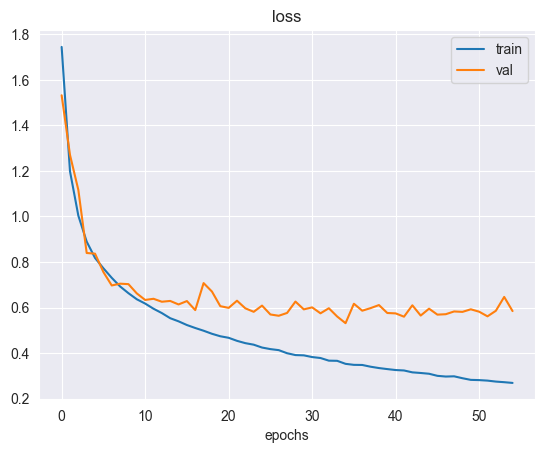

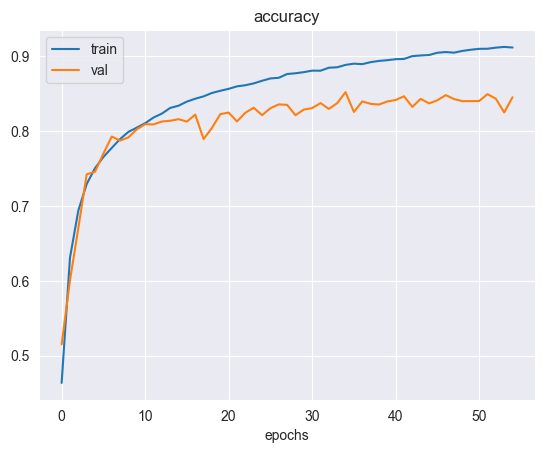

In [9]:
import matplotlib.pyplot as plt

plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.title("loss")
plt.xlabel("epochs")
plt.legend(["train", "val"])
plt.show()

plt.plot(history["train_accuracy"])
plt.plot(history["val_accuracy"])
plt.title("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "val"])
plt.show()

# Ewaluacja

Test Loss: 0.6160
Test Accuracy: 0.8221


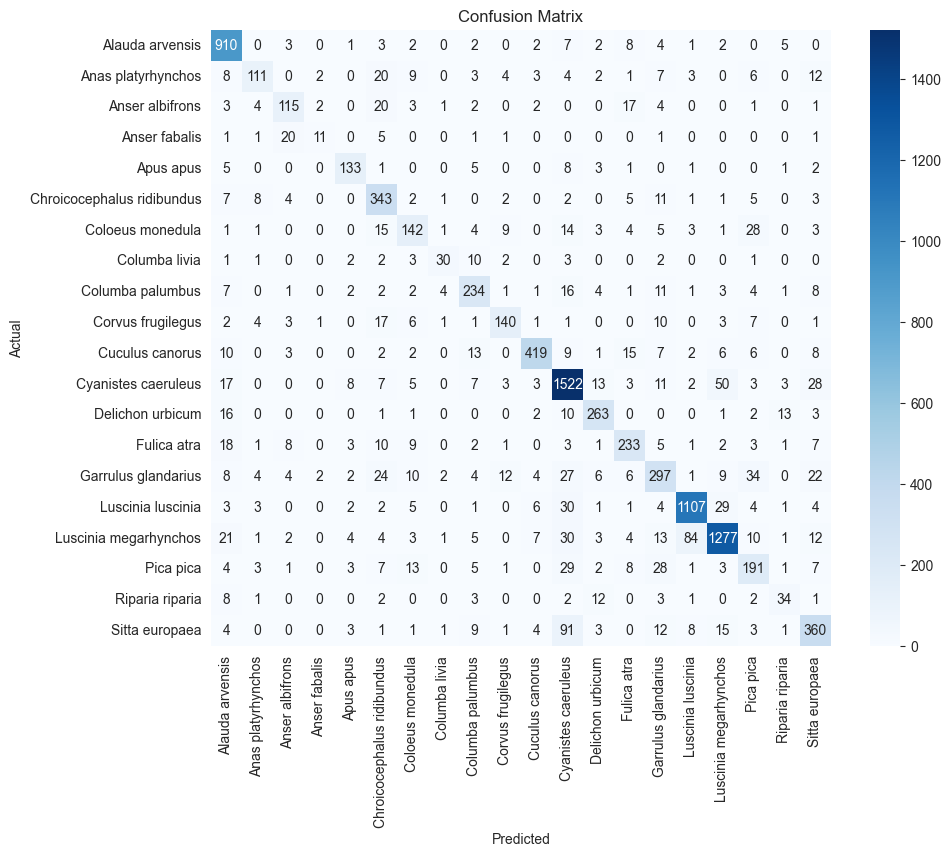


Classification Report:
                            precision    recall  f1-score   support

           Alauda arvensis       0.86      0.96      0.91       952
        Anas platyrhynchos       0.78      0.57      0.66       195
           Anser albifrons       0.70      0.66      0.68       175
             Anser fabalis       0.61      0.26      0.37        42
                 Apus apus       0.82      0.83      0.82       160
Chroicocephalus ridibundus       0.70      0.87      0.78       395
          Coloeus monedula       0.65      0.61      0.63       234
             Columba livia       0.71      0.53      0.61        57
          Columba palumbus       0.75      0.77      0.76       303
         Corvus frugilegus       0.79      0.71      0.75       198
           Cuculus canorus       0.92      0.83      0.88       503
       Cyanistes caeruleus       0.84      0.90      0.87      1685
          Delichon urbicum       0.82      0.84      0.83       312
               Fulica a

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate(model, test_loader, criterion, device, class_names=None):
    model.eval()  # Przełączenie modelu w tryb ewaluacji
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Predykcja
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            # Predykcja klas
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Zbieranie predykcji i prawdziwych etykiet do analizy
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Wyliczenie średniej straty i dokładności
    avg_loss = test_loss / total
    accuracy = correct / total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Macierz pomyłek
    if class_names:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        # Raport klasyfikacji
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

model.load_state_dict(torch.load("ghostnet_model.pth"))

# Przygotowanie danych testowych
dataset_test = SpectrogramDataset(root_dir="../data/merged-data/test", labels_dict=labels_dict, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

# Definicja kryterium strat
criterion = torch.nn.CrossEntropyLoss()

# Ewaluacja
evaluate(model, dataloader_test, criterion, device=device, class_names=labels_dict.keys())

In [19]:
import time
import numpy as np

ts = []
for _ in range(100):
    rand = torch.randn((1, 1, 224, 224)).to(device)
    t = time.time()
    _ = model(rand)
    ts.append(time.time() - t)

print(np.mean(ts), "sec")

0.0021147704124450683 sec
